<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/hr-analytics/hr-analytics/HR_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.0 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 186 kB 48.7 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 295 kB/s 
Mounted at /content/gdrive


In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
import zipfile, gzip

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [5]:
!rm -r ~/hr-analytics
!mkdir ~/hr-analytics

rm: cannot remove '/root/hr-analytics': No such file or directory


In [13]:
api.dataset_list_cli(search='HR Analytics')

ref                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
pavansubhasht/ibm-hr-analytics-attrition-dataset     IBM HR Analytics Employee Attrition & Performance   50KB  2017-03-31 06:55:16          81236       1674  0.88235295       
arashnic/hr-analytics-job-change-of-data-scientists  HR Analytics: Job Change of Data Scientists        295KB  2020-12-07 00:25:10          27515       1036  1.0              
vjchoudhary7/hr-analytics-case-study                 HR Analytics Case Study                             10MB  2018-08-10 03:53:41          13150        204  0.7352941        
giripujar/hr-analytics                               HR Analytics                                       111KB  2018-01-2

In [22]:
api.dataset_download_cli(dataset='arashnic/hr-analytics-job-change-of-data-scientists',
                         path='hr-analytics',
                         unzip=True,
                         force=True)

100%|██████████| 295k/295k [00:00<00:00, 54.6MB/s]

In [51]:
train_ds = pd.read_csv('hr-analytics/aug_train.csv', low_memory=False)
test_ds = pd.read_csv('hr-analytics/aug_test.csv')

In [52]:
train_ds.head()

,enrollee_id,city,city_development_index,gender,...,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,...,NaN,1,36,1.0
1,29725,city_40,0.776,Male,...,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,...,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,...,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,...,Funded Startup,4,8,0.0


In [53]:
dep_var = 'target'

In [60]:
train_final = train_ds[list(xs.columns) + [dep_var]]

In [61]:
train_final

,city,gender,relevent_experience,enrolled_university,...,enrollee_id,city_development_index,training_hours,target
0,city_103,Male,Has relevent experience,no_enrollment,...,8949,0.920,36,1.0
1,city_40,Male,No relevent experience,no_enrollment,...,29725,0.776,47,0.0
2,city_21,NaN,No relevent experience,Full time course,...,11561,0.624,83,0.0
3,city_115,NaN,No relevent experience,NaN,...,33241,0.789,52,1.0
4,city_162,Male,Has relevent experience,no_enrollment,...,666,0.767,8,0.0
...,...,...,...,...,...,...,...,...,...
19153,city_173,Male,No relevent experience,no_enrollment,...,7386,0.878,42,1.0
19154,city_103,Male,Has relevent experience,no_enrollment,...,31398,0.920,52,1.0
19155,city_103,Male,Has relevent experience,no_enrollment,...,24576,0.920,44,0.0
19156,city_65,Male,Has relevent experience,no_enrollment,...,5756,0.802,97,0.0


In [97]:
cont,cat = cont_cat_split(train_final, max_card=2000, dep_var=dep_var)
cont, cat

(['enrollee_id', 'city_development_index'],
 ['city',
  'gender',
  'relevent_experience',
  'enrolled_university',
  'education_level',
  'major_discipline',
  'experience',
  'company_size',
  'company_type',
  'last_new_job',
  'training_hours'])

In [122]:
procs = [Categorify, FillMissing, Normalize]
tabular_data = TabularPandas(train_final, 
                      procs, 
                      cat, 
                      cont,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_final)), 
                      y_names=dep_var,
                      y_block = CategoryBlock )

In [123]:
dls = tabular_data.dataloaders(512)
dls.show_batch()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,enrollee_id,city_development_index,target
0,city_21,Male,Has relevent experience,Full time course,Graduate,Other,3,1000-4999,Pvt Ltd,1,57,25068.999851,0.624,1.0
1,city_142,#na#,Has relevent experience,no_enrollment,Graduate,STEM,8,#na#,#na#,3,168,583.999861,0.727,1.0
2,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,11,500-999,Pvt Ltd,2,34,20958.000124,0.920,0.0
3,city_16,Male,No relevent experience,Full time course,High School,#na#,9,#na#,#na#,never,12,774.999844,0.910,0.0
4,city_103,#na#,Has relevent experience,no_enrollment,Graduate,STEM,16,100-500,NGO,1,21,3111.000317,0.920,0.0
5,city_143,Male,No relevent experience,no_enrollment,Graduate,STEM,>20,#na#,#na#,never,31,6849.000269,0.740,0.0
6,city_103,Male,Has relevent experience,Part time course,Graduate,STEM,19,1000-4999,Public Sector,>4,142,6304.000025,0.920,0.0
7,city_160,#na#,Has relevent experience,no_enrollment,Graduate,STEM,10,<10,Pvt Ltd,2,53,1113.000275,0.920,0.0
8,city_160,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,10/49,Early Stage Startup,2,64,15353.000031,0.920,0.0
9,city_103,Male,Has relevent experience,Part time course,Graduate,STEM,6,1000-4999,#na#,1,26,32974.000082,0.920,0.0


In [124]:
learn = tabular_learner(dls,    
                        metrics=[accuracy])

SuggestedLRs(valley=0.0008317637839354575)

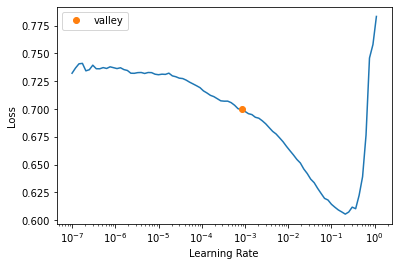

In [125]:
learn.lr_find()

In [126]:
learn.fit_one_cycle(2, 4e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.587584,0.631693,0.770817,00:00
1,0.505582,0.503322,0.789611,00:00


SuggestedLRs(valley=0.0012022644514217973)

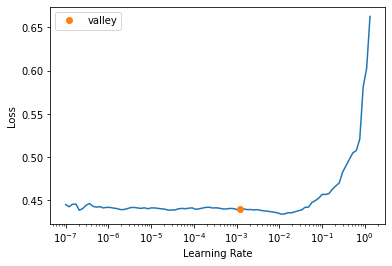

In [127]:
learn.lr_find()

In [129]:
learn.fit_one_cycle(8, 3e-5, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.441230,0.466943,0.788306,00:00
1,0.440330,0.464756,0.787784,00:00
2,0.438576,0.464864,0.791438,00:00
3,0.436570,0.464646,0.789350,00:00
4,0.434841,0.463843,0.790655,00:00
5,0.433906,0.464487,0.789350,00:00
6,0.433172,0.464625,0.789350,00:00
7,0.432681,0.463601,0.789611,00:00
